In [1]:
import import_ipynb
from Reservoir import Reservoir

import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Ignore warnings
import warnings
import time
warnings.filterwarnings("ignore")


from tqdm.notebook import tqdm_notebook

importing Jupyter notebook from Reservoir.ipynb


In [2]:
class Trainer():
    def __init__(self, device, model, dataset, optimizer, criterion):
        self.device = device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.dataset = dataset
        
    def initializeEpoch(self):
        self.summation = 0
        self.val_summation = 0
        self.validation_training = enumerate(self.dataset.training_pool.validloader)
    
    def fit(self, epochs, report_period):
        save_path = "snapshots/{}_{:.5f}_weights.pt"
        iters_trained = []
        training_losses = []
        validation_losses = []
        count = 0
        
        for epoch in range(epochs):
            self.initializeEpoch()
            dataloader = self.dataset.training_pool.dataloader
            for i_batch, sampled_batch in tqdm_notebook(enumerate(dataloader),
                                                       total=len(dataloader)):
                
                torch.cuda.empty_cache()
                self.model.train()
                images = sampled_batch['image']
                images = np.transpose(images,(0,3,1,2)).to(self.device).float()
                labels = sampled_batch['label'].to(self.device).long()
                
                #backwards pass
                self.optimizer.zero_grad()
                prediction = self.model(images)
                
                #calculate loss
                labels = labels.reshape((10,))
                loss = self.criterion(prediction, labels)
                loss.backward()
                self.optimizer.step()
                
                #get batch losses
                val_i,batch = self.validationBatch()
                val_loss = self.score(batch)
                #val_loss = val_loss.data
                self.summation += float(loss)
                self.val_summation += float(val_loss)
                
                if i_batch % report_period == 0:
                    iters_trained.append(count)
                    average_loss = round(self.summation/float(i_batch+1),5)
                    average_val_loss = round(self.val_summation/float(i_batch+1),5)
                    training_losses.append(average_loss)
                    validation_losses.append(average_val_loss)
                count += 1
                #print(torch.cuda.max_memory_cached(self.device))
                
                    
            print("Epoch: "+str(epoch))
            print("Training Loss: "+str(average_loss))
            print("Validation Loss: "+str(average_val_loss))
            #self.model.save_weights(self.optimizer, epoch, save_path.format(count,average_loss))
            #torch.save(self.model, save_path.format(count,average_loss))  
            plt.plot(iters_trained,training_losses, label="training")
            plt.plot(iters_trained,validation_losses, label="validation")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            plt.show() 
            
        
        
    def validationBatch(self):
        try:
            val_i,batch = next(self.validation_training)
        except StopIteration:
            self.validation_training = enumerate(self.dataset.training_pool.validloader)
            val_i,batch = next(self.validation_training)
        return val_i,batch
        
                
    def score(self, sampled_batch):
        self.model.eval()
        #inputs and forward pass
        images = sampled_batch['image']
        images = np.transpose(images,(0,3,1,2)).to(self.device).float()
        labels = sampled_batch['label'].to(self.device).long()
        labels = labels.reshape((10,))

        #forward pass
        prediction = self.model(images)

        #calculate loss
        loss = self.criterion(prediction, labels)
        torch.cuda.empty_cache()
        return loss

importing Jupyter notebook from Model.ipynb
[1, 28, 28]
units after conv 588
fc parameters:  5890
Total training stacks 5400
Total validation stacks 600
Total testing stacks 10000



Epoch: 0
Training Loss: 0.28857
Validation Loss: 0.23172


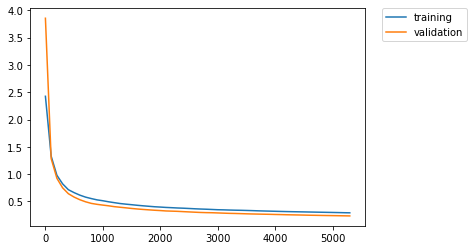

In [3]:
import torch.optim as optim
from Model import ConvNet

if __name__ == "__main__":

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    outputs = 10
    image_shape = [1,28,28]
    net = ConvNet(outputs, image_shape).to(device)
    optimizer = optim.Adam(net.parameters(), amsgrad=True, weight_decay=0.01)
    criterion = nn.CrossEntropyLoss() #don't use reduction!!!
    
    dataset = Reservoir("./data/training/images/train-images-idx3-ubyte.gz",
                        "./data/training/labels/train-labels-idx1-ubyte.gz",
                        "./data/testing/images/t10k-images-idx3-ubyte.gz",
                        "./data/testing/labels/t10k-labels-idx1-ubyte.gz")
    
    trainer = Trainer(device, net, dataset, optimizer, criterion)
    
    epochs = 1
    report_period = 100
    trainer.fit(epochs, report_period)